## Introduction

In this publication, we are going to understand how general Bézier curves are created, and we'll implement different parallel algorithms to make them run faster. The aim of this post is to handle general curves, that means that we need the mathematical tools to create them. You may be familiar with some code targeting these curves, especially for cubic Béziers (since they are the most used ones), here we design the following algorithms for n-curve points and n-dimensions, and we'll use them in 2D and 3D scenarios.

In [1]:
%%capture

# we'll be using python's Ray multiprocessing framework:

! pip install -U ray[default]

import ray

context = ray.init()

In [11]:
print(context.dashboard_url)

127.0.0.1:8265


## Control Points

Let's start by creating random points in space that will later conform the curve control points. We define a function that takes the number of points for the curve and the dimension of the space (again, its use will make sense for 2 or 3 dimensions, but you can try it with more). Bézier curves touches the first and last control points, the rest of them act as tensors that create the curve shape.

In [12]:
import random

import numpy as np

import matplotlib.pyplot as plt

In [13]:
# generate n -dimensional control points:

def r_n_dim_control(dim, elems):
  
    N, R = 5, 10

    return [random.sample(range((R + 1) * (R + 1)), dim) for _ in range(elems) ]

In [14]:
# generate linear random 2D control points:

def l_2_dim_control(elems):

    x = list(np.arange(0, elems))

    y = [random.randrange(0, 5) for _ in range(elems)]

    return list(zip(x,y))

In [15]:
points = r_n_dim_control(2, 25)

We can take two different approaches to render a bezier curve along the control points created. The first one will use the Casteljau's algorithm to recursively calculate the interpolation point on the curve. The second will handle the interpolation based on a more symbolic / analytical way.

The point of this article is to compare these two algorithms when used with many control points. In any case possible, a parallel implementation is going to be compared with the sequential algorithm, take a look at the execution times along the notebook and make your own conclusions.

## Casteljau's algorithm

The Casteljau's algorithm takes a completely geometric approach to calculate the interpolated point in the curve. The easiest way to implement is by using its recursive version, it can take some time but for lower grade curves success as quadratic or cubic is more than enough.

In [16]:
import numpy as np

def point_2_point_interpolation(p1, p2, t):

    return (1 - t) * p1 + t * p2

In [17]:
# casteljaus:

def get_point_R (points, t):

    if (len(points) == 1) : 

        return points [0]

    # ELSE

    recursive_call = []

    for i in range(0, len(points) -1):

        # this operation has to work for any dimension:
        # we use numpy arrays and the operations are redefined:
        newPoint = (1 - t) * points [i] + t * points [i + 1]

        recursive_call.append(newPoint)

    return get_point_R (recursive_call, t)

Let's take a look at how the algorithm uses control points recursively to finally return the interpolation point (t) in the curve defined by those points. In order to generate the curve, a bunch of points need to be computed, the next 'for' statement generates 1000 evenly space t values to calculate the desired points at the curve t positions.

In [18]:
%%time

bezier = []

for t in np.linspace(0.0, 1.0, num=1000):

    p = get_point_R(np.array(points), t)

    bezier.append(p)

CPU times: total: 2.66 s
Wall time: 3.24 s


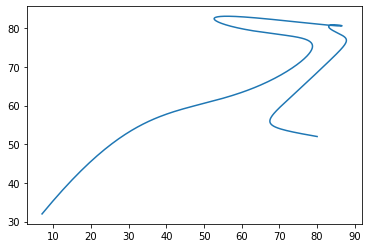

In [19]:
plt.plot(*zip(*bezier))

In [20]:
from ray.util.multiprocessing import Pool
from ray import available_resources

cores = int(available_resources()['CPU'])
pool = Pool(cores)

params = []
for t in np.linspace(0.0, 1.0, num=1000):
    params.append([np.array(points), t])

def f(args):

    points, t = args
    return get_point_R(points, t)

bezier = pool.map(f, params)

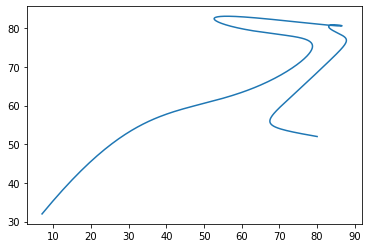

In [21]:
plt.plot(*zip(*bezier))

Finally, we are going to see how nested parallelism can be used to render multiple curves at once. Let's redesign the previous code to run within nested pools.

In [22]:
def bezier_render(map_func, points, n):

    params = []

    for t in np.linspace(0.0, 1.0, num=n):

        params.append([np.array(points), t])

    def pll_point_R(args):

        points, t = args

        return get_point_R(points, t)

    return map_func(pll_point_R, params)

In [23]:
curves_control = [r_n_dim_control(2, 25) for _ in range(3)]

2023-06-09 16:25:38,385	WARNING worker.py:2019 -- WARNING: 16 PYTHON worker processes have been started on node: fd0df0a0701e2678216c477c50444b5801226a73a6d66ed2bc8696c0 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


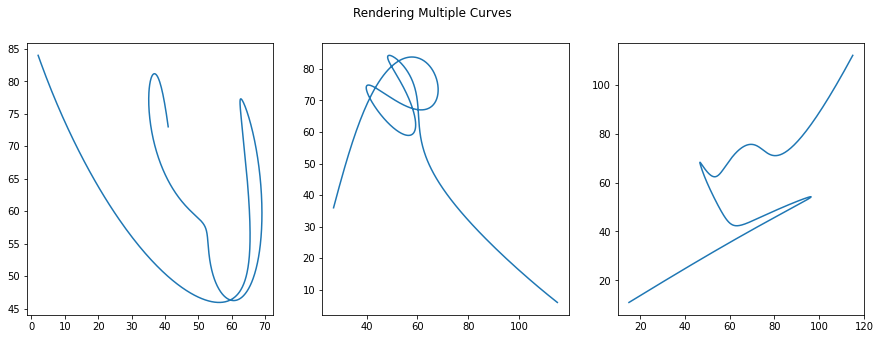

In [24]:
# visualize 3 curves running in parallel.

from ray.util.multiprocessing import Pool

pool1 = Pool()
pool2 = Pool()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# change figsize; pero listo,

fig.suptitle('Rendering Multiple Curves')

params = []
for control in curves_control:
    params.append([pool2.map, control, 1000])

# lista compresión con esto;

def pll_render(args):
    func, points, n = args
    return bezier_render(func, points, n)

res = pool1.map(pll_render, params)

for idx, bezier in enumerate(res):

    axs[idx].plot(*zip(*bezier))

## Aanalytic Approach

Bézier curves are polynomials of t, they can be implemented using simple polynomials, increasing the degree when a new control point is introduced. However, here we need the more general approach to test n-control points and n-dimension curves. Take a look at the following formulas.

$$linear -> (1-t)+t $$
$$cuadratic -> (1-t)² + 2 * (1-t)* t + t² $$
$$cubic -> (1-t)³ + 3 * (1-t)² * t + 3 * (1-t) * t² + t³$$

For each of the formulas described, there are two general patterns that we can identify. The binomial terms follow a unique pattern that can be easily computed and the polynomials, if we substitute (1-t) for 'a' and t for 'b' we see another recursive pattern that can be summarized in an elegant formula.

$$linear -> 1+1$$
$$quadratic -> 1+2+1 $$
$$cubic -> 1+3+3+1$$

Rename (1-t) to a and t to b, and removing the weights used for the binomial calculations, we get this pattern for each of the curves (understanding the way each grade works allows us to write the general pattern to be reused for n-grade curves): 

$$linear -> a+b $$
$$quadratic -> a²+a* b²+b$$
$$cubic -> a³+ a²*b + a*b²+ b³$$

Those patterns described above generate the following formula, notice this representation works for each of the control point coordinate components. Taking a binomial and then computing the corresponding polynomial will give us a general reusable function.

$$ bezier(n,k,t) =  \sum_{n=1}^{n} \binom{n}{k} * (1-t)^{n-k} * t^{k}$$

Since the previous formula needs to be calculated for each coordinate component (x,y,z), we can further parallelize calculating those components individually. This analytic formulation allows more granularity, and it will be used within the rendering technique.

Working from python, the standard multiprocessing library won't be enough, it can't handle nested parallelism. We use Ray for working with distributed computing and implement the map-reduce pattern to handle the parallel behavior needed.

The following functions represent the building blocks for the written formula. Notice there are heavy math operations such as factorials (used for binomial coefficient calculations)

In [25]:
def fact(number):

    fact = 1

    for i in range(2,number+1):
        
        fact = fact * i

    return fact

In [26]:
def binomial(x, y):
        
        return fact(x) // fact(y) // fact(x - y)

In [27]:
def polynomial(n, i, t):

    return pow((1 - t), (n - i)) * pow (t, i)

In [28]:
def bezier_func(n, t, w):

    sum = 0

    for i in range(0, n+1, 1):

        sum += binomial(n, i) * polynomial (n, i, t) * w[i] 

    return sum

In [29]:
bezier_func(10, 0.5, list(zip(*points))[0])

73.123046875

In [30]:
def get_point_sec(points, t):

    grade = len(points)-1

    i_comps = list(zip(*points))

    t_point = [ bezier_func(grade, t, i_comps[x]) for x in range(len(i_comps)) ]

    return t_point

In [31]:
b2 = [ get_point_sec(points, t) for t in np.linspace(0.0, 1.0, num=1000) ]

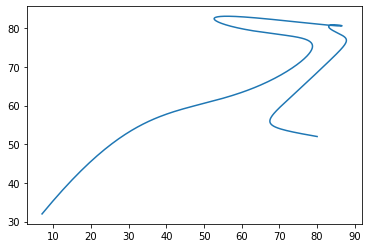

In [32]:
plt.plot(*zip(*b2))

The following function uses ray's multiprocessing to parallel execute the Bézier function. The way the parameters are passed to the map-reduce behaviour is pretty elegant since list comprehension can be used to mimic the sequential function header.

To be able to execute in parallel with ray, the function needs to be decorated with the @ray.remote annotation. Here, we do it dynamically since we also use the function in the previous sequential approach.

In [33]:
# dinamycall decorate bezier_func;

bezier_func = ray.remote(bezier_func)

In [34]:
def get_point_pll(points, t):

    grade = len(points)-1

    i_comps = list(zip(*points))

    t_point = ray.get( [bezier_func.remote(grade, t, i_comps[x]) for x in range(len(i_comps))] )

    return t_point

Once the point calculation is parallelized, we proceed to render the curve. First let's make a sequential approach and then we will rewrite it to also run in parallel. The ray architecture simply allows us to run nested parallel algorithms. We can abstract each individual process in a map-reduce and let the framework manage the hardware resources to run it.

In [35]:
%%time

# secuential

bezier = [get_point_pll(points, t) for t in np.linspace(0.0, 1.0, num=10)]

2023-06-09 16:25:57,945	WARNING worker.py:2019 -- WARNING: 24 PYTHON worker processes have been started on node: fd0df0a0701e2678216c477c50444b5801226a73a6d66ed2bc8696c0 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


CPU times: total: 203 ms
Wall time: 6.23 s


In [36]:
# decorate function before use it in parallel.

get_point_pll = ray.remote(get_point_pll)

In [37]:
%%time

import time

bezier = ray.get( [get_point_pll.remote(points, t) for t in np.linspace(0.0, 1.0, num=1000) ] )

2023-06-09 16:26:04,547	WARNING worker.py:2019 -- WARNING: 30 PYTHON worker processes have been started on node: fd0df0a0701e2678216c477c50444b5801226a73a6d66ed2bc8696c0 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2023-06-09 16:26:11,742	WARNING worker.py:2019 -- WARNING: 32 PYTHON worker processes have been started on node: fd0df0a0701e2678216c477c50444b5801226a73a6d66ed2bc8696c0 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2023-06-09 16:26:21,199	WARNING worker.py:2019 -- WARNING: 38 PYTHON worker processes have been started on node: fd0df0a0701e2678216c477c50444b5801226a73a6d66ed2bc8696c0 with address: 127.0.0.1. This could be a result of using a l

CPU times: total: 2.91 s
Wall time: 41.4 s


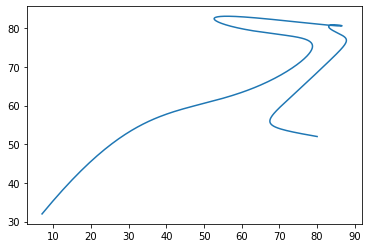

In [38]:
plt.plot(*zip(*bezier))

As a final exercise we can visualize the distributed process in a local machine. Taking consideration that this task can be easily executed in remote clusters for better performance, the local overhead is not considered.

In [39]:
points_3D = r_n_dim_control(3, 25)

In [40]:
def render_bezier_analytic (points):

    return ray.get( [get_point_pll.remote(points, t) for t in np.linspace(0.0, 1.0, num=1000) ] )

In [41]:
render_bezier_analytic = ray.remote(render_bezier_analytic)

In [42]:
points_3D_3 = [ r_n_dim_control(3, 25) for _ in range(3) ]

2023-06-09 16:27:06,672	WARNING worker.py:2019 -- WARNING: 40 PYTHON worker processes have been started on node: fd0df0a0701e2678216c477c50444b5801226a73a6d66ed2bc8696c0 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2023-06-09 16:27:17,009	WARNING worker.py:2019 -- WARNING: 44 PYTHON worker processes have been started on node: fd0df0a0701e2678216c477c50444b5801226a73a6d66ed2bc8696c0 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


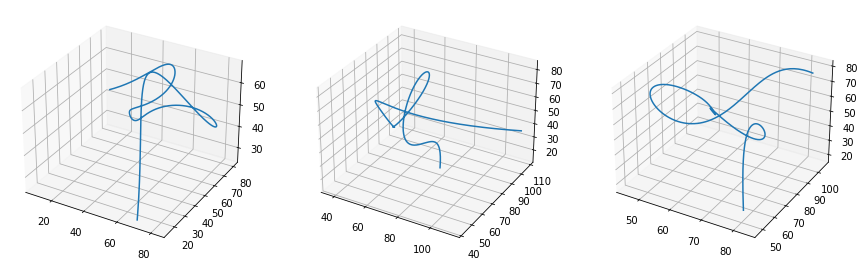

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(projection='3d'))

beziers = ray.get( [ render_bezier_analytic.remote(points_3D_3[x]) for x in range(3) ] )

for idx, bezier in enumerate(beziers):

    xs, ys, zs = list(zip(*bezier))

    axs[idx].plot(xs, ys, zs)

plt.show()

Since we are running a lot of parallel tasks, Ray dashboard allows us to visualize the task execution and the nested dependencies between the tasks. This example illustrates how to use distributed computing to calculate Bézier point coordinates and then render curves by giving different interpolation values.

![alt text](ray_capture.PNG "Title")